In [10]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

In [11]:
accuracies = [0.2, 0.6, 0.5, 0.1, 0.6, 0.5]
Shape = [1201, 1006, 1052, 1320, 1035, 1085]
Min = [1.457069651341291e-10, 1.8953799122906976e-08, 3.7910417027920744e-09, 1.864730767869872e-09, 2.375997203841347e-08, 6.03443771536222e-09]
Max = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Mean = [0.8787593422585893, 0.8725241907968498, 0.8835834288087651, 0.8682737015211405, 0.8780507058633462, 0.8742235579549197]
Gmean = [0.6351220025377092, 0.6333854582304509, 0.6371673435270344, 0.6319605699164628, 0.6076227822783787, 0.635646220311767]
Entropy = [7.010786282622528, 6.830101292632026, 6.884857657533949, 7.101693645521822, 6.857150552954218, 6.913037103494054]

norm_Shape = [1201, 1006, 1052, 1320, 1035, 1085]
norm_Min = [1.3805983500759617e-13, 2.1593389379987595e-11, 4.078451101777799e-12, 1.6269925274357134e-12, 2.6144839437869086e-11, 6.36186670591233e-12]
norm_Max = [0.0009475170585051069, 0.0011392644419181634, 0.0010758127769404514, 0.0008725080078419401, 0.0011003733251705823, 0.001054260066305193]
norm_Mean = [0.0008326394671107411, 0.0009940357852882703, 0.0009505703422053232, 0.0007575757575757576, 0.000966183574879227, 0.0009216589861751152]
norm_Gmean = [0.0006017889316364034, 0.0007215935305899968, 0.0006854727692155889, 0.0005513906578924701, 0.0006686119013850608, 0.0006701364263725282]
norm_Entropy = [7.010786282622528, 6.830101292632026, 6.884857657533949, 7.101693645521822, 6.857150552954218, 6.913037103494054]

accuracies.extend([0.3, 0.3, 0.0, 0.1, 0.3, 0.2, 0.7, 0.6, 0.2, 0.2, 0.5, 0.2])
Shape.extend([822, 700, 797, 577, 618, 621, 698, 571, 527, 503, 618, 699])
Min.extend([5.44772066433229e-09, 6.041972880252352e-08, 8.186175436293087e-07, 1.0488951526307312e-07, 1.8699130612862024e-07, 1.9941154127118333e-08, 4.0046212578606606e-08, 3.4320765465946254e-08, 8.298330442472104e-06, 2.46650636028206e-07, 3.9278597995802437e-07, 2.174191589888458e-06])
Max.extend([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])
Mean.extend([0.8781214534694503, 0.8696521073966857, 0.8529587365822683, 0.854456167785778, 0.8778267025937906, 0.8737227634919129, 0.8548697524354367, 0.8504120757702417, 0.8249757003593129, 0.8646864905450099, 0.8566803627743683, 0.8778075071034118])
Gmean.extend([0.5933160802150108, 0.5755346147073249, 0.5283880368460094, 0.5293848636496068, 0.6249706201311415, 0.5543571810776456, 0.5381055907487919, 0.5601416061342144, 0.5295596733927477, 0.5439971991836662, 0.5407672545070025, 0.5905375349171156])
Entropy.extend([6.623200487101165, 6.460492180486299, 6.573813296073874, 6.251608823460343, 6.344575794232899, 6.3415040765386665, 6.44134592030967, 6.247851729002319, 6.151561242949837, 6.119336930866491, 6.324958068106857, 6.462292699565786])
norm_Min.extend([7.547244604580962e-12, 9.925106551825768e-11, 1.2041891350034424e-09, 2.1274848503117038e-10, 3.4468640349703194e-10, 3.6752343700640336e-11, 6.711291074120312e-11, 7.067916965490037e-11, 1.9087056223583517e-08, 5.670946900572323e-10, 7.419056709683812e-10, 3.5434094991186532e-09])
norm_Max.extend([0.0013853949329661532, 0.00164269299921307, 0.0014710033328441965, 0.0020283103082093237, 0.0018433284981706187, 0.0018430399497619933, 0.0016758865925077773, 0.0020593704334779376, 0.002300107998338207, 0.0022991819489668027, 0.0018888293086419888, 0.0016297595463058707])
norm_Mean.extend([0.0012165450121654502, 0.0014285714285714284, 0.0012547051442910915, 0.0017331022530329288, 0.0016181229773462784, 0.0016103059581320449, 0.0014326647564469911, 0.0017513134851138354, 0.0018975332068311194, 0.00198807157057654, 0.0016181229773462782, 0.0014306151645207437])
norm_Gmean.extend([0.000821977091177215, 0.0009454266823845131, 0.0007772605632354837, 0.0010737567759504848, 0.0011520261546070964, 0.0010217024311635447, 0.0009018039448893783, 0.001153539062233645, 0.0012180444403680271, 0.0012507485406515837, 0.0010214170394666894, 0.0009624341849831058])
norm_Entropy.extend([6.623200487101165, 6.4604921804863, 6.573813296073874, 6.251608823460343, 6.344575794232899, 6.341504076538668, 6.441345920309672, 6.247851729002319, 6.151561242949838, 6.119336930866492, 6.324958068106858, 6.462292699565786])

accuracies.extend([0.2, 0.4, 0.7, 0.6, 0.5, 0.7, 0.3, 0.5, 0.2, 0.6, 0.4, 0.7])
Shape.extend([1175, 1032, 936, 1553, 1416, 1159, 1160, 1263, 828, 1111, 979, 1132])
Min.extend([6.015407979923643e-07, 1.0694577748042132e-08, 2.1319446720417144e-07, 4.270609966834033e-09, 2.089822981531493e-08, 4.56461046329604e-08, 3.725519375984045e-08, 3.84950429225241e-11, 4.271271979988811e-08, 2.760712718080897e-07, 1.0273327076232076e-08, 3.7186526838357505e-07])
Mean.extend([0.811573925497204, 0.8548342247639477, 0.8691704477368115, 0.8759623055707602, 0.8871049363025263, 0.8628379910020363, 0.8598468224325972, 0.8716569327621221, 0.8709052056870351, 0.8649638427517061, 0.8546417694283159, 0.8526574578862998])
Gmean.extend([0.5056547552580676, 0.6232732682221567, 0.6096680629946735, 0.6405114822563528, 0.6742941522895456, 0.6187322961058885, 0.6180249502654956, 0.6434683667787633, 0.5923450227459545, 0.603523741456698, 0.5668017545430423, 0.5968094081125358])
Entropy.extend([6.938110054210833, 6.845478894986773, 6.753589156581524, 7.2655687128113575, 7.183850230164881, 6.964922557326569, 6.964580333300628, 7.059832808271526, 6.632177847518471, 6.921939422517028, 6.785417836508678, 6.93332529306569])
norm_Min.extend([6.308108223154271e-10, 1.2122774959099189e-11, 2.6205661647172527e-10, 3.139301557904021e-12, 1.6636855766733466e-11, 4.5644770364598277e-11, 3.735147413097248e-11, 3.4966798346462696e-14, 5.923194631227846e-11, 2.8728252123940387e-10, 1.2278471564991797e-11, 3.852694704377376e-10])
norm_Max.extend([0.0010486584192140437, 0.0011335440486482525, 0.0012291905128136353, 0.0007350944203015818, 0.0007960892340528007, 0.0009999707692830999, 0.0010025843476147967, 0.0009083454827375455, 0.001386751922841346, 0.0010406099821900616, 0.0011951796602873413, 0.001036045856372734])
norm_Mean.extend([0.000851063829787234, 0.0009689922480620154, 0.0010683760683760685, 0.000643915003219575, 0.0007062146892655367, 0.0008628127696289905, 0.0008620689655172414, 0.000791765637371338, 0.0012077294685990338, 0.0009000900090008999, 0.0010214504596527069, 0.0008833922261484099])
norm_Gmean.extend([0.0005302591163169886, 0.0007065077038747704, 0.0007493981989985183, 0.00047083641674574087, 0.0005367983152224675, 0.0006187142101173044, 0.0006196221415715996, 0.0005844915842479952, 0.0008214355992784546, 0.0006280328298485338, 0.0006774299284450228, 0.000618321914319258])
norm_Entropy.extend([6.938110054210833, 6.845478894986774, 6.753589156581524, 7.2655687128113575, 7.183850230164881, 6.964922557326569, 6.964580333300628, 7.059832808271526, 6.632177847518471, 6.921939422517029, 6.785417836508678, 6.93332529306569])

accuracies.extend([0.4, 0.2, 0.4, 0.3, 0.4, 0.5, 0.2, 0.4, 0.5, 0.6, 0.4, 0.3])
Shape.extend([791, 869, 1022, 937, 928, 903, 954, 915, 945, 860, 993, 852])
Min.extend([6.839733840590093e-07, 2.475239198902386e-07, 4.0608243918568774e-08, 1.0467361864851814e-08, 5.527352295717806e-08, 6.86463732017938e-09, 6.972726328818139e-09, 6.86463732017938e-09, 5.399362809786118e-08, 1.0467361864851814e-08, 5.0712065594860276e-08, 2.5207259605786527e-08])
Mean.extend([0.818389266719992, 0.785609992249171, 0.8464644501652456, 0.8463198704528864, 0.8146409145453452, 0.8104209167998694, 0.8160527778177865, 0.7704779635462408, 0.8089296576126632, 0.7764236249250875, 0.8093472888039988, 0.7969465709442075])
Gmean.extend([0.5331165301029376, 0.4743484450380281, 0.5552999669520136, 0.5541705979827293, 0.5137480529674286, 0.4878041549912046, 0.49391713911835083, 0.43696475715441635, 0.4998027576024576, 0.4495107702957434, 0.49582279451560474, 0.48257015784653917])
Entropy.extend([6.550658335954754, 6.622420378693223, 6.819855473074185, 6.732455535410769, 6.703908302744399, 6.669057492376188, 6.725064223184837, 6.650892018489904, 6.714555886957243, 6.596588327583626, 6.765134460827257, 6.601422014911907])
norm_Min.extend([1.0565809925096787e-09, 3.6256877478393737e-10, 4.694124348167092e-11, 1.3199671096730885e-11, 7.311440523273595e-11, 9.380353501489557e-12, 8.956451899025736e-12, 9.737249115494327e-12, 7.0631746347257e-11, 1.567617292275977e-11, 6.309967694778126e-11, 3.7124176866396654e-11])
norm_Max.extend([0.0015447691637347732, 0.0014647827771340804, 0.0011559535442064825, 0.0012610313149728632, 0.0013227744735825817, 0.0013664747406122888, 0.0012844978386730738, 0.0014184651950760135, 0.001308149662016413, 0.0014976240551498022, 0.00124427345263129, 0.0014727573503418238])
norm_Mean.extend([0.0012642225031605561, 0.001150747986191024, 0.0009784735812133072, 0.0010672358591248667, 0.0010775862068965517, 0.0011074197120708748, 0.0010482180293501047, 0.0010928961748633878, 0.001058201058201058, 0.0011627906976744186, 0.0010070493454179255, 0.0011737089201877932])
norm_Gmean.extend([0.0008235419763802987, 0.0006948174326520359, 0.0006419009648959217, 0.0006988264778934592, 0.0006795728103180663, 0.000666572056161203, 0.0006344354976811075, 0.0006198192994983807, 0.0006538168084325271, 0.0006731981426438223, 0.0006169391404252279, 0.0007107087470241054])
norm_Entropy.extend([6.550658335954754, 6.622420378693223, 6.819855473074185, 6.732455535410769, 6.703908302744399, 6.669057492376188, 6.725064223184839, 6.650892018489904, 6.714555886957244, 6.596588327583626, 6.765134460827257, 6.601422014911908])

In [2]:
accuracies = [0.3, 0.3, 0.0, 0.1, 0.3, 0.2, 0.7, 0.6, 0.2, 0.2, 0.5, 0.2]
Shape = [822, 700, 797, 577, 618, 621, 698, 571, 527, 503, 618, 699]
Min = [5.44772066433229e-09, 6.041972880252352e-08, 8.186175436293087e-07, 1.0488951526307312e-07, 1.8699130612862024e-07, 1.9941154127118333e-08, 4.0046212578606606e-08, 3.4320765465946254e-08, 8.298330442472104e-06, 2.46650636028206e-07, 3.9278597995802437e-07, 2.174191589888458e-06]
Max = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Mean = [0.8781214534694503, 0.8696521073966857, 0.8529587365822683, 0.854456167785778, 0.8778267025937906, 0.8737227634919129, 0.8548697524354367, 0.8504120757702417, 0.8249757003593129, 0.8646864905450099, 0.8566803627743683, 0.8778075071034118]
Gmean = [0.5933160802150108, 0.5755346147073249, 0.5283880368460094, 0.5293848636496068, 0.6249706201311415, 0.5543571810776456, 0.5381055907487919, 0.5601416061342144, 0.5295596733927477, 0.5439971991836662, 0.5407672545070025, 0.5905375349171156]
Entropy = [6.623200487101165, 6.460492180486299, 6.573813296073874, 6.251608823460343, 6.344575794232899, 6.3415040765386665, 6.44134592030967, 6.247851729002319, 6.151561242949837, 6.119336930866491, 6.324958068106857, 6.462292699565786]
norm_Min = [7.547244604580962e-12, 9.925106551825768e-11, 1.2041891350034424e-09, 2.1274848503117038e-10, 3.4468640349703194e-10, 3.6752343700640336e-11, 6.711291074120312e-11, 7.067916965490037e-11, 1.9087056223583517e-08, 5.670946900572323e-10, 7.419056709683812e-10, 3.5434094991186532e-09]
norm_Max = [0.0013853949329661532, 0.00164269299921307, 0.0014710033328441965, 0.0020283103082093237, 0.0018433284981706187, 0.0018430399497619933, 0.0016758865925077773, 0.0020593704334779376, 0.002300107998338207, 0.0022991819489668027, 0.0018888293086419888, 0.0016297595463058707]
norm_Mean = [0.0012165450121654502, 0.0014285714285714284, 0.0012547051442910915, 0.0017331022530329288, 0.0016181229773462784, 0.0016103059581320449, 0.0014326647564469911, 0.0017513134851138354, 0.0018975332068311194, 0.00198807157057654, 0.0016181229773462782, 0.0014306151645207437]
norm_Gmean = [0.000821977091177215, 0.0009454266823845131, 0.0007772605632354837, 0.0010737567759504848, 0.0011520261546070964, 0.0010217024311635447, 0.0009018039448893783, 0.001153539062233645, 0.0012180444403680271, 0.0012507485406515837, 0.0010214170394666894, 0.0009624341849831058]
norm_Entropy = [6.623200487101165, 6.4604921804863, 6.573813296073874, 6.251608823460343, 6.344575794232899, 6.341504076538668, 6.441345920309672, 6.247851729002319, 6.151561242949838, 6.119336930866492, 6.324958068106858, 6.462292699565786]

In [4]:
accuracies = [0.2, 0.4, 0.7, 0.6, 0.5, 0.7, 0.3, 0.5, 0.2, 0.6, 0.4, 0.7]
Shape = [1175, 1032, 936, 1553, 1416, 1159, 1160, 1263, 828, 1111, 979, 1132]
Min = [6.015407979923643e-07, 1.0694577748042132e-08, 2.1319446720417144e-07, 4.270609966834033e-09, 2.089822981531493e-08, 4.56461046329604e-08, 3.725519375984045e-08, 3.84950429225241e-11, 4.271271979988811e-08, 2.760712718080897e-07, 1.0273327076232076e-08, 3.7186526838357505e-07]
Mean = [0.811573925497204, 0.8548342247639477, 0.8691704477368115, 0.8759623055707602, 0.8871049363025263, 0.8628379910020363, 0.8598468224325972, 0.8716569327621221, 0.8709052056870351, 0.8649638427517061, 0.8546417694283159, 0.8526574578862998]
Gmean = [0.5056547552580676, 0.6232732682221567, 0.6096680629946735, 0.6405114822563528, 0.6742941522895456, 0.6187322961058885, 0.6180249502654956, 0.6434683667787633, 0.5923450227459545, 0.603523741456698, 0.5668017545430423, 0.5968094081125358]
Entropy = [6.938110054210833, 6.845478894986773, 6.753589156581524, 7.2655687128113575, 7.183850230164881, 6.964922557326569, 6.964580333300628, 7.059832808271526, 6.632177847518471, 6.921939422517028, 6.785417836508678, 6.93332529306569]
norm_Min = [6.308108223154271e-10, 1.2122774959099189e-11, 2.6205661647172527e-10, 3.139301557904021e-12, 1.6636855766733466e-11, 4.5644770364598277e-11, 3.735147413097248e-11, 3.4966798346462696e-14, 5.923194631227846e-11, 2.8728252123940387e-10, 1.2278471564991797e-11, 3.852694704377376e-10]
norm_Max = [0.0010486584192140437, 0.0011335440486482525, 0.0012291905128136353, 0.0007350944203015818, 0.0007960892340528007, 0.0009999707692830999, 0.0010025843476147967, 0.0009083454827375455, 0.001386751922841346, 0.0010406099821900616, 0.0011951796602873413, 0.001036045856372734]
norm_Mean = [0.000851063829787234, 0.0009689922480620154, 0.0010683760683760685, 0.000643915003219575, 0.0007062146892655367, 0.0008628127696289905, 0.0008620689655172414, 0.000791765637371338, 0.0012077294685990338, 0.0009000900090008999, 0.0010214504596527069, 0.0008833922261484099]
norm_Gmean = [0.0005302591163169886, 0.0007065077038747704, 0.0007493981989985183, 0.00047083641674574087, 0.0005367983152224675, 0.0006187142101173044, 0.0006196221415715996, 0.0005844915842479952, 0.0008214355992784546, 0.0006280328298485338, 0.0006774299284450228, 0.000618321914319258]
norm_Entropy = [6.938110054210833, 6.845478894986774, 6.753589156581524, 7.2655687128113575, 7.183850230164881, 6.964922557326569, 6.964580333300628, 7.059832808271526, 6.632177847518471, 6.921939422517029, 6.785417836508678, 6.93332529306569]

In [2]:
accuracies = [0.4, 0.2, 0.4, 0.3, 0.4, 0.5, 0.2, 0.4, 0.5, 0.6, 0.4, 0.3]
Shape = [791, 869, 1022, 937, 928, 903, 954, 915, 945, 860, 993, 852]
Min = [6.839733840590093e-07, 2.475239198902386e-07, 4.0608243918568774e-08, 1.0467361864851814e-08, 5.527352295717806e-08, 6.86463732017938e-09, 6.972726328818139e-09, 6.86463732017938e-09, 5.399362809786118e-08, 1.0467361864851814e-08, 5.0712065594860276e-08, 2.5207259605786527e-08]
Mean = [0.818389266719992, 0.785609992249171, 0.8464644501652456, 0.8463198704528864, 0.8146409145453452, 0.8104209167998694, 0.8160527778177865, 0.7704779635462408, 0.8089296576126632, 0.7764236249250875, 0.8093472888039988, 0.7969465709442075]
Gmean = [0.5331165301029376, 0.4743484450380281, 0.5552999669520136, 0.5541705979827293, 0.5137480529674286, 0.4878041549912046, 0.49391713911835083, 0.43696475715441635, 0.4998027576024576, 0.4495107702957434, 0.49582279451560474, 0.48257015784653917]
Entropy = [6.550658335954754, 6.622420378693223, 6.819855473074185, 6.732455535410769, 6.703908302744399, 6.669057492376188, 6.725064223184837, 6.650892018489904, 6.714555886957243, 6.596588327583626, 6.765134460827257, 6.601422014911907]
norm_Min = [1.0565809925096787e-09, 3.6256877478393737e-10, 4.694124348167092e-11, 1.3199671096730885e-11, 7.311440523273595e-11, 9.380353501489557e-12, 8.956451899025736e-12, 9.737249115494327e-12, 7.0631746347257e-11, 1.567617292275977e-11, 6.309967694778126e-11, 3.7124176866396654e-11]
norm_Max = [0.0015447691637347732, 0.0014647827771340804, 0.0011559535442064825, 0.0012610313149728632, 0.0013227744735825817, 0.0013664747406122888, 0.0012844978386730738, 0.0014184651950760135, 0.001308149662016413, 0.0014976240551498022, 0.00124427345263129, 0.0014727573503418238]
norm_Mean = [0.0012642225031605561, 0.001150747986191024, 0.0009784735812133072, 0.0010672358591248667, 0.0010775862068965517, 0.0011074197120708748, 0.0010482180293501047, 0.0010928961748633878, 0.001058201058201058, 0.0011627906976744186, 0.0010070493454179255, 0.0011737089201877932]
norm_Gmean = [0.0008235419763802987, 0.0006948174326520359, 0.0006419009648959217, 0.0006988264778934592, 0.0006795728103180663, 0.000666572056161203, 0.0006344354976811075, 0.0006198192994983807, 0.0006538168084325271, 0.0006731981426438223, 0.0006169391404252279, 0.0007107087470241054]
norm_Entropy = [6.550658335954754, 6.622420378693223, 6.819855473074185, 6.732455535410769, 6.703908302744399, 6.669057492376188, 6.725064223184839, 6.650892018489904, 6.714555886957244, 6.596588327583626, 6.765134460827257, 6.601422014911908]

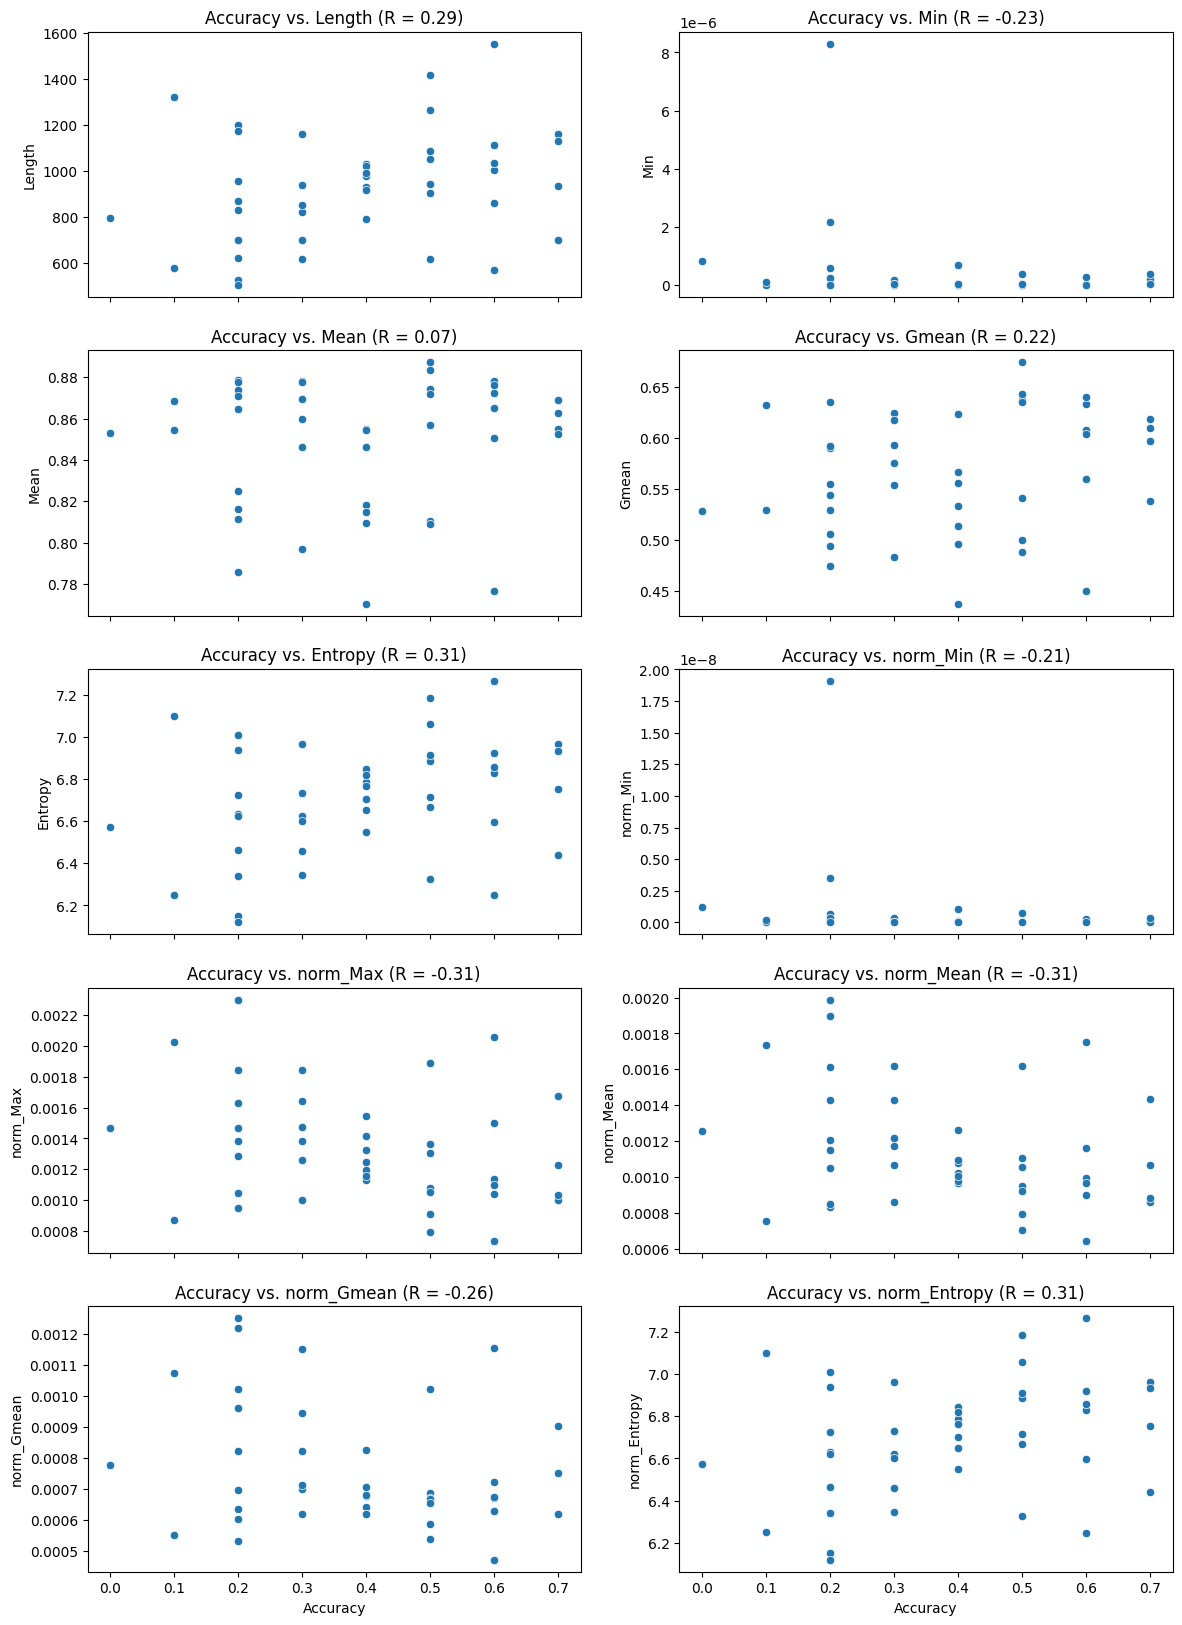

In [12]:
fig, ax = plt.subplots(5, 2, sharex=True, figsize=(14, 20))
for i, (label, y) in enumerate(
    [
        ("Length", Shape),
        ("Min", Min),
        # ("Max", Max),
        ("Mean", Mean),
        ("Gmean", Gmean),
        ("Entropy", Entropy),
        ("norm_Min", norm_Min),
        ("norm_Max", norm_Max),
        ("norm_Mean", norm_Mean),
        ("norm_Gmean", norm_Gmean),
        ("norm_Entropy", norm_Entropy),
    ]
):
    # plt.figure(i)
    
    sct = sns.scatterplot(x=np.array(accuracies), y=np.array(y), ax=ax[i//2,i%2])
    pears = pearsonr(x=np.array(accuracies), y=np.array(y))
    sct.set(xlabel="Accuracy", ylabel=label, title=f"Accuracy vs. {label} (R = {pears.statistic:.2f})")

In [7]:
from numpy.random import default_rng

rng = default_rng()

In [9]:
for i in range(10):
    print(rng.choice(5, 3, replace=False))

[4 0 2]
[0 1 2]
[3 1 0]
[3 2 4]
[1 2 4]
[0 4 3]
[2 1 0]
[0 3 2]
[4 2 3]
[2 0 3]
